"""
# Cuaderno 04: Síntesis Multimodal - Aprender a Leer para Afinar el Oído

### El "Porqué" Cognitivo: La Fusión de la Vista y el Sonido 🧠

Este cuaderno aborda la hipótesis más avanzada de nuestro proyecto: que el **aprendizaje multimodal** (la combinación de la vista y el oído) es clave para desarrollar una conciencia fonológica robusta. En el `Cuaderno 03`, observamos que generar una "imagen auditiva" a partir del deletreo era una tarea inmensamente difícil. Esto es cognitivamente plausible; un cerebro no aprende en un vacío unisensorial.

Cuando un niño aprende a leer, el cerebro forja una conexión poderosa entre el **símbolo visual** (grafema 'c'), su **nombre hablado** (sonido "ce") y su **sonido fundamental** (/k/). Esta triangulación de información enriquece y refina la representación neuronal del fonema. Proponemos que este refuerzo visual puede ser el catalizador que nuestro modelo auditivo necesita para generalizar.

### El "Cómo" Técnico: Un Experimento de Dos Fases ⚙️

Este cuaderno se divide en dos grandes experimentos:

1.  **Fase 1: Entrenar la Vía Visual Primaria (Grafema → Sonido)**:
    -   **Tarea**: Entrenamos un modelo que aprende la asociación fundamental de la lectura: ver la imagen de una letra y "escuchar" su nombre en la mente.
    -   **Arquitectura**: Usamos una **CNN** para "ver" la imagen y un **Decoder LSTM** para "generar" la secuencia de embedding del sonido del nombre de la letra.
    -   **Validación**: La calidad del sonido "imaginado" se juzga mediante la **pérdida perceptual** utilizando nuestro **Experto en Fonemas** congelado del `Cuaderno 02`.
    -   **Resultado**: Un modelo `visual_to_sound_model.pth` entrenado y congelado.

2.  **Fase 2: Entrenar la Vía de Síntesis Multimodal**:
    -   **Tarea**: Revisitamos la tarea del `Cuaderno 03` (deletreo -> palabra), pero esta vez enriquecemos la entrada.
    -   **Input Multimodal**: El modelo `Seq2Seq` principal ahora recibe una **entrada fusionada**:
        -   **Input Auditivo**: La secuencia de embeddings de los nombres de las letras deletreadas (ej. "ce", "a", "ese", "a").
        -   **Input Visual**: Las imágenes de las letras ('c', 'a', 's', 'a') se pasan a través de nuestra nueva **Vía Visual Primaria** para generar una segunda secuencia de embeddings.
    -   **Hipótesis a Probar**: ¿Esta señal visual adicional, aunque generada, proporciona suficiente contexto para que el modelo auditivo finalmente **generalice** en la tarea de conciencia fonológica? Lo mediremos con la **Similaridad del Coseno**.
"""

In [16]:
# ===================================================================
# Celda 2: Configuración e Instalación
# ===================================================================
%pip install torch scikit-learn seaborn pandas matplotlib torchvision --quiet

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torchvision.datasets import EMNIST
from torchvision import transforms
from PIL import Image
from pathlib import Path
import numpy as np, pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob, warnings

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

Note: you may need to restart the kernel to use updated packages.


In [17]:
# ===================================================================
# Celda 3: Parámetros Globales y Rutas
# ===================================================================
# --- Parámetros Generales ---
LANGUAGES = ['es', 'en']; RANDOM_SEED = 24
MODEL_ARCHITECTURE = "multimodal_synthesis"

# --- Parámetros Fase 1: Vía Visual Primaria ---
EPOCHS_VISUAL = 250; BATCH_SIZE_VISUAL = 64; LR_VISUAL = 0.001

# --- Parámetros Fase 2: Vía Multimodal ---
EPOCHS_MULTIMODAL = 1000; BATCH_SIZE_MULTIMODAL = 64; LR_MULTIMODAL = 0.0003
RECONSTRUCTION_LOSS_WEIGHT = 5.0; PERCEPTUAL_LOSS_WEIGHT = 1.0
VOCAB_SPLIT_RATIO = 0.2

# --- Hiperparámetros de Modelos ---
EMBED_DIM = 1024; LSTM_HIDDEN_DIM = 256; LSTM_N_LAYERS = 2; LSTM_DROPOUT = 0.4
N_HEADS = 32; N_LAYERS = 5; TRANSFORMER_DROPOUT = 0.2; DECODER_DROPOUT = 0.4

# --- Rutas ---
project_root = Path.cwd().parent
dictionaries_dir = project_root/"data/01_raw/dictionaries"
phoneme_embedding_dir_base = project_root/"data/02_processed/wav2vec2_embeddings"
word_embedding_dir_base = project_root/"data/02_processed/word_embeddings"
visual_dir_base = project_root/"data/02_processed/visual"
model_dir = project_root/"results/trained_models"
figure_dir = project_root/"results/figures"

for path in [model_dir, figure_dir]: path.mkdir(parents=True, exist_ok=True)
torch.manual_seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Fase 1: Entrenamiento de la Vía Visual Primaria (Grafema → Sonido)

En esta fase, entrenamos un modelo que aprende la asociación fundamental de la lectura. El modelo tomará una imagen de una letra y generará la "imagen auditiva" (la secuencia de embeddings) del nombre de esa letra. Lo validaremos usando nuestro **Experto en Fonemas** como juez perceptual.


In [18]:
# ===================================================================
# Celda 2: Configuración e Instalación
# ===================================================================
%pip install torch scikit-learn seaborn pandas matplotlib torchvision --quiet

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torchvision.datasets import EMNIST
from torchvision import transforms
from PIL import Image
from pathlib import Path
import numpy as np, pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import glob, warnings

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

Note: you may need to restart the kernel to use updated packages.


## Fase 1: Entrenamiento de la Vía Visual Primaria (Grafema → Sonido)

En esta fase, entrenamos un modelo para que aprenda la asociación fundamental de la lectura. El modelo tomará una imagen de una letra y generará la "imagen auditiva" (la secuencia de embeddings) del nombre de esa letra. Lo validaremos usando nuestro **Experto en Fonemas** como juez perceptual.


In [19]:
# ===================================================================
# Celda 5: Definiciones de Clases y Funciones Globales
# ===================================================================
class SequentialClassifierLSTM(nn.Module):
    def __init__(self, embed_dim, num_classes, hidden_dim, n_layers, dropout): super().__init__(); self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True, dropout=dropout if n_layers > 1 else 0, bidirectional=True); self.classifier_head = nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x_padded, x_lengths): packed_input = nn.utils.rnn.pack_padded_sequence(x_padded, x_lengths.cpu(), batch_first=True, enforce_sorted=False); _, (hidden, _) = self.lstm(packed_input); hidden_concat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1); return self.classifier_head(hidden_concat)
class GraphemeToSoundDataset(Dataset):
    def __init__(self, visual_dir, phoneme_embedding_dir, transform=None):
        self.image_paths=sorted(glob.glob(str(visual_dir / "*/*.png"))); self.phoneme_embedding_dir=phoneme_embedding_dir; self.transform=transform; self.data=[]
        for img_path in self.image_paths:
            label_char=Path(img_path).parent.name; target_path=self.phoneme_embedding_dir/f"{label_char}.npy"
            if target_path.exists(): self.data.append((img_path, target_path, label_char))
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        img_path, target_path, label_char=self.data[idx]; image=Image.open(img_path).convert("L")
        if self.transform: image=self.transform(image)
        target_sequence=torch.tensor(np.load(target_path), dtype=torch.float32); return image, target_sequence, label_char
def collate_fn_visual(batch):
    images, target_sequences, labels_char = zip(*batch); target_lengths = torch.tensor([len(seq) for seq in target_sequences])
    padded_targets = pad_sequence(target_sequences, batch_first=True, padding_value=0.0); return torch.stack(images), padded_targets, target_lengths, list(labels_char)
class VisualEncoderCNN(nn.Module):
    def __init__(self, output_dim): super().__init__(); self.cnn = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.Flatten(), nn.Linear(128*3*3, output_dim), nn.ReLU())
    def forward(self, x): return self.cnn(x)
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim): super().__init__(); self.attn = nn.Linear(enc_hid_dim + dec_hid_dim, dec_hid_dim); self.v = nn.Linear(dec_hid_dim, 1, bias=False)
    def forward(self, hidden, encoder_outputs, mask=None):
        hidden = hidden.unsqueeze(1).repeat(1, encoder_outputs.shape[1], 1); energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        if mask is not None: attention = attention.masked_fill(mask == 0, -1e10)
        return torch.softmax(attention, dim=1)
class Seq2SeqDecoder(nn.Module):
    def __init__(self, output_dim, dec_hid_dim, enc_hid_dim, dropout, attention):
        super().__init__(); self.output_dim=output_dim; self.attention=attention; self.rnn=nn.LSTM(enc_hid_dim+output_dim, dec_hid_dim, num_layers=1); self.fc_out=nn.Linear(enc_hid_dim+dec_hid_dim+output_dim, output_dim); self.dropout=nn.Dropout(dropout)
    def forward(self, input, hidden, cell, encoder_outputs, mask):
        input=input.unsqueeze(0); a=self.attention(hidden.squeeze(0), encoder_outputs, mask).unsqueeze(1); weighted=torch.bmm(a, encoder_outputs).permute(1,0,2); rnn_input=torch.cat((input, weighted), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell)); prediction=self.fc_out(torch.cat((output.squeeze(0), weighted.squeeze(0), input.squeeze(0)), dim=1)); return prediction, hidden, cell
class VisualToAuditoryModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__(); self.encoder=encoder; self.decoder=decoder; self.device=device; self.fc_h=nn.Linear(EMBED_DIM, LSTM_HIDDEN_DIM); self.fc_c=nn.Linear(EMBED_DIM, LSTM_HIDDEN_DIM)
    def forward(self, src_image, trg_sequence, teacher_forcing_ratio=0.5):
        batch_size, trg_len, trg_vocab_size = src_image.shape[0], trg_sequence.shape[1], self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device); encoder_output = self.encoder(src_image).unsqueeze(1)
        hidden = torch.tanh(self.fc_h(encoder_output.squeeze(1))).unsqueeze(0); cell = torch.tanh(self.fc_c(encoder_output.squeeze(1))).unsqueeze(0)
        input_token = torch.zeros(batch_size, trg_vocab_size).to(self.device)
        for t in range(trg_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell, encoder_output, mask=None); outputs[:,t,:] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input_token = trg_sequence[:,t,:] if teacher_force and self.training else output
        return outputs
class PhonemeEncoder(nn.Module):
    def __init__(self, embed_dim, n_heads, n_layers, dropout): super().__init__(); self.pos_encoder=PositionalEncoding(embed_dim,dropout); encoder_layer=nn.TransformerEncoderLayer(embed_dim,n_heads,dim_feedforward=embed_dim*2,dropout=dropout,batch_first=True); self.transformer_encoder=nn.TransformerEncoder(encoder_layer,n_layers)
    def forward(self, src, src_padding_mask): src = self.pos_encoder(src); return self.transformer_encoder(src, src_key_padding_mask=src_padding_mask)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=50): super().__init__(); self.dropout=nn.Dropout(p=dropout); position=torch.arange(max_len).unsqueeze(1); div_term=torch.exp(torch.arange(0,d_model,2)*(-np.log(10000.0)/d_model)); pe=torch.zeros(1,max_len,d_model); pe[0,:,0::2]=torch.sin(position*div_term); pe[0,:,1::2]=torch.cos(position*div_term); self.register_buffer('pe',pe)
    def forward(self, x): x=x+self.pe[:,:x.size(1),:]; return self.dropout(x)
class MultimodalDataset(Dataset):
    def __init__(self, phoneme_dir, word_dir, visual_dir, word_list, transform=None):
        self.phoneme_dir=Path(phoneme_dir); self.word_dir=Path(word_dir); self.visual_dir=Path(visual_dir); self.transform = transform
        self.word_list = [w for w in word_list if (self.word_dir/f"{w}.npy").exists() and all((self.phoneme_dir/f"{p}.npy").exists() for p in w) and all((self.visual_dir/p).exists() for p in w)]
        self.word_to_int = {word: i for i, word in enumerate(self.word_list)}; print(f"Dataset Multimodal inicializado con {len(self.word_list)} palabras válidas.")
    def __len__(self): return len(self.word_list)
    def __getitem__(self, idx):
        word = self.word_list[idx]; auditory_input_seq = [torch.tensor(np.load(self.phoneme_dir/f"{p}.npy"), dtype=torch.float32).mean(dim=0) for p in word]
        auditory_input = torch.stack(auditory_input_seq); visual_input_seq = []
        for char in word:
            img_path = sorted(glob.glob(str(self.visual_dir / char / "*.png")))[0]; image = Image.open(img_path).convert("L")
            if self.transform: image = self.transform(image)
            visual_input_seq.append(image)
        visual_input = torch.stack(visual_input_seq); target_sequence = torch.tensor(np.load(self.word_dir/f"{word}.npy"), dtype=torch.float32)
        label = torch.tensor(self.word_to_int[word], dtype=torch.long); return auditory_input, visual_input, target_sequence, label, word
def collate_fn_multimodal(batch):
    auditory_inputs, visual_inputs, target_sequences, labels, words = zip(*batch)
    padded_auditory = pad_sequence(auditory_inputs, batch_first=True, padding_value=0.0); target_lengths = torch.tensor([len(seq) for seq in target_sequences])
    padded_targets = pad_sequence(target_sequences, batch_first=True, padding_value=0.0); padded_visuals = pad_sequence(visual_inputs, batch_first=True, padding_value=0.0)
    return padded_auditory, padded_visuals, padded_targets, target_lengths, torch.stack(labels), list(words)
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device): super().__init__(); self.encoder=encoder; self.decoder=decoder; self.device=device; self.fc=nn.Linear(EMBED_DIM, LSTM_HIDDEN_DIM)
    def forward(self, src_phonemes, src_mask, trg_words, teacher_forcing_ratio = 0.5):
        batch_size, trg_len, trg_vocab_size = src_phonemes.shape[0], trg_words.shape[1], self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device); encoder_outputs = self.encoder(src_phonemes, src_mask)
        hidden = torch.tanh(self.fc(torch.mean(encoder_outputs, dim=1))).unsqueeze(0); cell = torch.zeros(1, batch_size, LSTM_HIDDEN_DIM).to(self.device)
        input = torch.zeros(batch_size, trg_vocab_size).to(self.device)
        for t in range(trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs, src_mask); outputs[:,t,:] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input = trg_words[:,t,:] if teacher_force and self.training else output
        return outputs

In [20]:
# ===================================================================
# Celda 6: Fase 1 - Bucle de Entrenamiento de la Vía Visual Primaria
# ===================================================================
results_visual = {}
for lang in LANGUAGES:
    print(f"=====================================================\nEntrenando Vía Visual Primaria para: {lang.upper()}\n=====================================================")
    expert_model_path = model_dir / f"{lang}_phoneme_expert.pth"
    if not expert_model_path.exists(): print(f"ERROR: No se encontró el modelo experto en fonemas. Saltando."); continue
    checkpoint = torch.load(expert_model_path, map_location=device)
    phoneme_label_map = checkpoint['label_map']; num_classes_phonemes = len(phoneme_label_map)
    phoneme_expert = SequentialClassifierLSTM(EMBED_DIM, num_classes_phonemes, LSTM_HIDDEN_DIM, LSTM_N_LAYERS, LSTM_DROPOUT).to(device)
    phoneme_expert.load_state_dict(checkpoint['model_state_dict'])
    phoneme_expert.eval(); [p.requires_grad_(False) for p in phoneme_expert.parameters()]
    print("Modelo Experto en Fonemas cargado y congelado.")
    transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    dataset = GraphemeToSoundDataset(visual_dir_base, phoneme_embedding_dir_base / lang, transform=transform)
    if len(dataset) == 0: print("No se encontraron datos. Saltando."); continue
    loader = DataLoader(dataset, batch_size=BATCH_SIZE_VISUAL, shuffle=True, collate_fn=collate_fn_visual)
    encoder = VisualEncoderCNN(output_dim=EMBED_DIM); attention_dummy = Attention(EMBED_DIM, LSTM_HIDDEN_DIM)
    decoder = Seq2SeqDecoder(EMBED_DIM, LSTM_HIDDEN_DIM, EMBED_DIM, DECODER_DROPOUT, attention_dummy)
    visual_model = VisualToAuditoryModel(encoder, decoder, device).to(device)
    optimizer = optim.Adam(visual_model.parameters(), lr=LR_VISUAL)
    criterion_mse = nn.MSELoss(reduction='none'); criterion_perceptual = nn.CrossEntropyLoss()
    phoneme_expert.train()
    for epoch in tqdm(range(EPOCHS_VISUAL), desc=f"Entrenando Vía Visual ({lang.upper()})"):
        visual_model.train()
        for batch in loader:
            if batch[0] is None: continue
            images, target_seqs, target_lengths, labels_char = batch
            images, target_seqs = images.to(device), target_seqs.to(device)
            optimizer.zero_grad(); output_seq = visual_model(images, target_seqs)
            true_indices_mapped = torch.tensor([phoneme_label_map.get(t, -1) for t in labels_char if t in phoneme_label_map], device=device, dtype=torch.long)
            if len(true_indices_mapped) == 0: continue
            mask = (target_seqs.sum(dim=2) != 0).float().unsqueeze(2)
            loss_r = ((criterion_mse(output_seq, target_seqs) * mask).sum() / mask.sum())
            logits_from_pred = phoneme_expert(output_seq, target_lengths)
            loss_p = criterion_perceptual(logits_from_pred, true_indices_mapped)
            loss = loss_r + loss_p; loss.backward(); optimizer.step()
    print("Entrenamiento de la Vía Visual Primaria finalizado.")
    visual_model.eval()
    model_path = model_dir / f"{lang}_visual_to_sound_model.pth"
    torch.save(visual_model.state_dict(), model_path)
    print(f"Modelo de Vía Visual guardado en: {model_path}")
    results_visual[lang] = {'model': visual_model}

Entrenando Vía Visual Primaria para: ES
Modelo Experto en Fonemas cargado y congelado.


Entrenando Vía Visual (ES):   0%|          | 0/250 [00:00<?, ?it/s]

Entrenamiento de la Vía Visual Primaria finalizado.
Modelo de Vía Visual guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_visual_to_sound_model.pth
Entrenando Vía Visual Primaria para: EN
Modelo Experto en Fonemas cargado y congelado.


Entrenando Vía Visual (EN):   0%|          | 0/250 [00:00<?, ?it/s]

Entrenamiento de la Vía Visual Primaria finalizado.
Modelo de Vía Visual guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_visual_to_sound_model.pth



--- Evaluando el rendimiento de la Vía Visual Primaria ---

--- Generando métricas para: ES ---


Evaluando Vía Visual (ES):   0%|          | 0/5 [00:00<?, ?it/s]

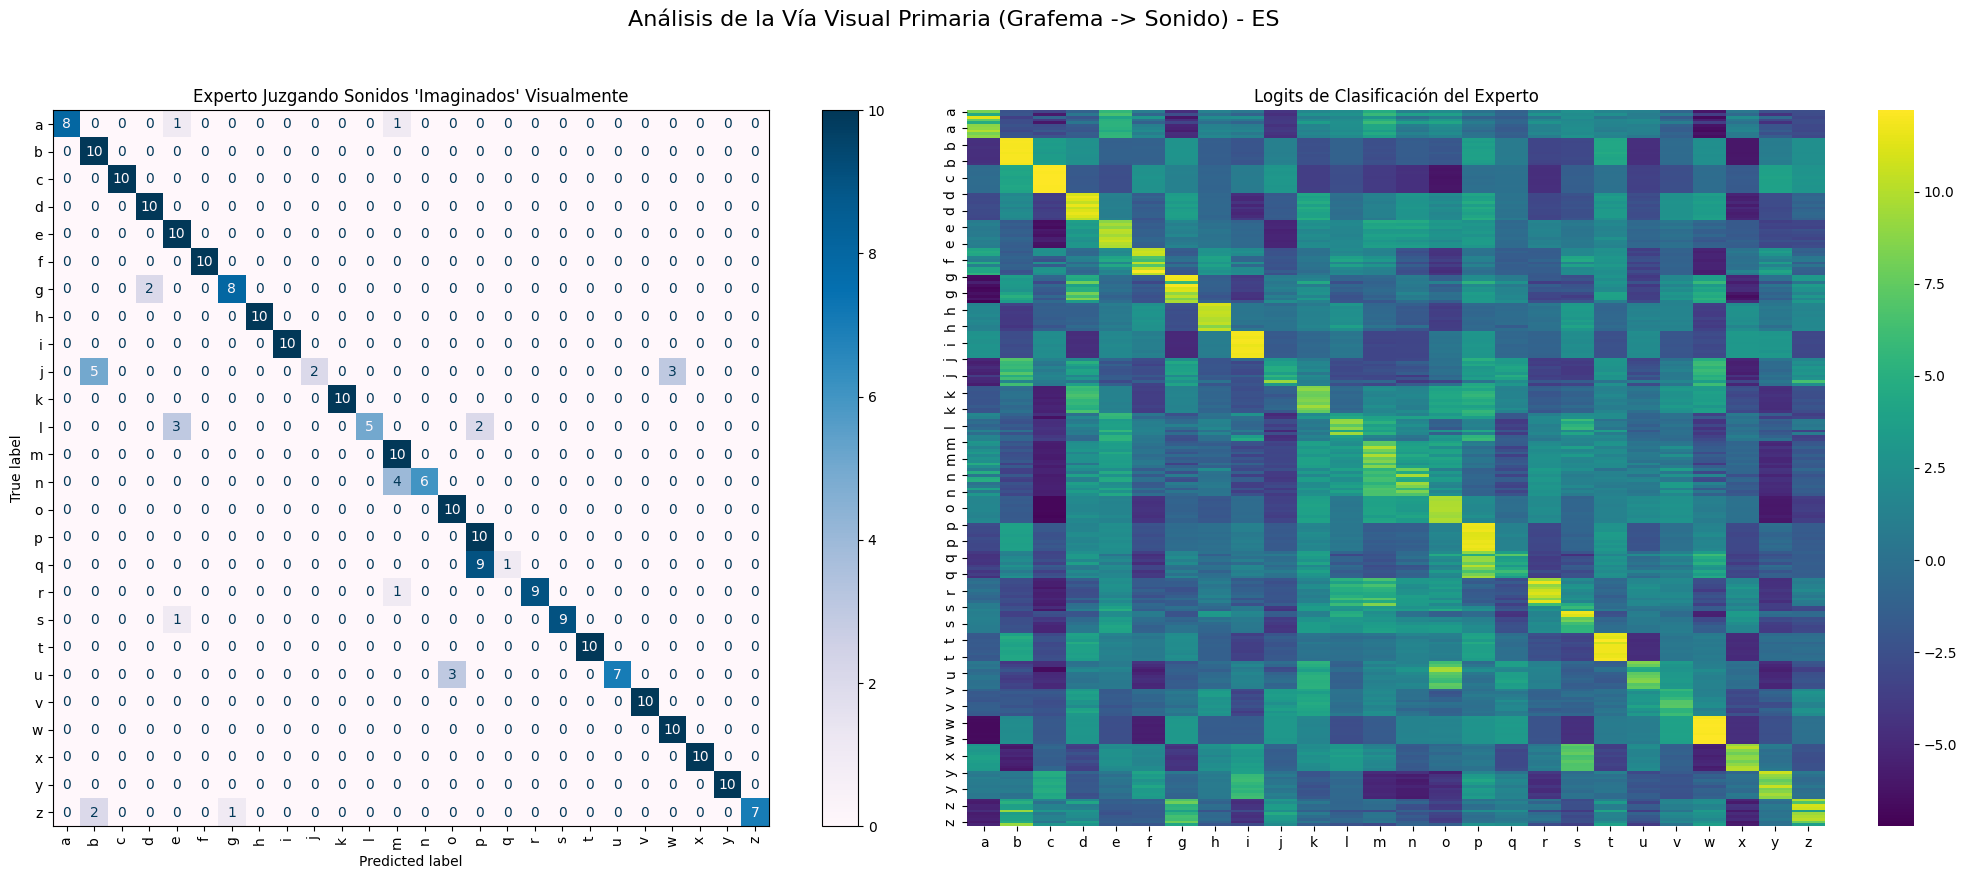


--- Generando métricas para: EN ---


Evaluando Vía Visual (EN):   0%|          | 0/5 [00:00<?, ?it/s]

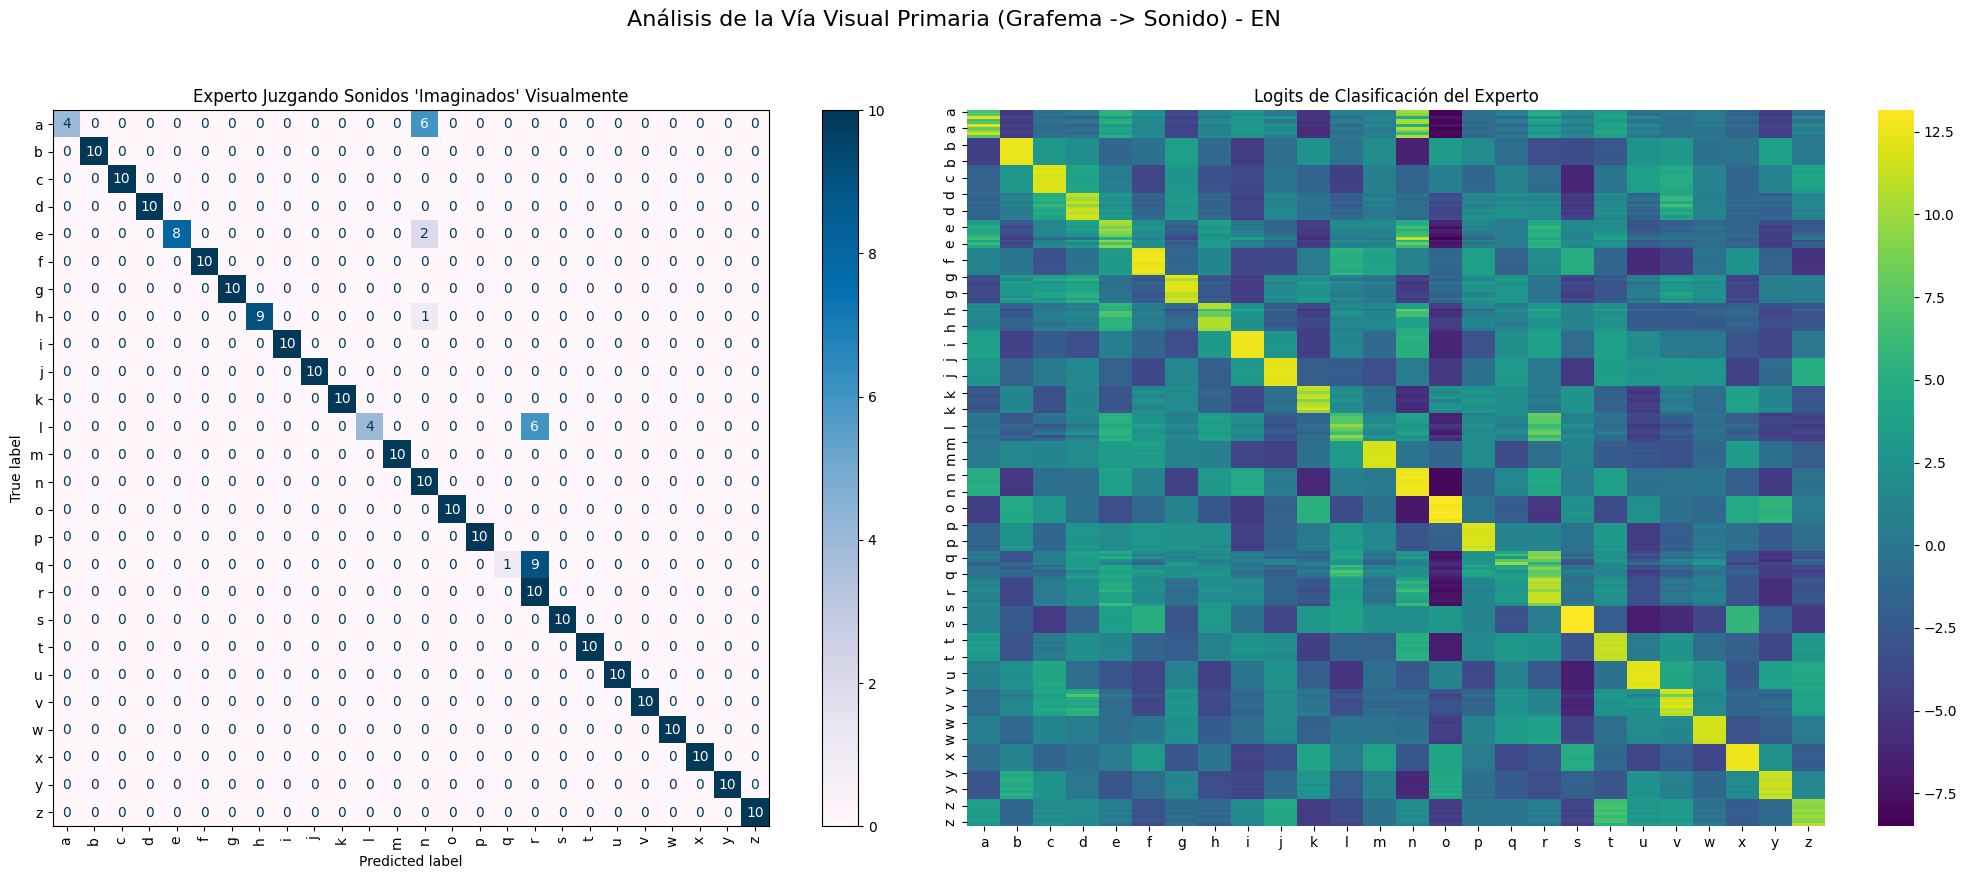

In [21]:
# ===================================================================
# Celda 7: Fase 1 - Evaluación de la Vía Visual Primaria
# ===================================================================
print("\n--- Evaluando el rendimiento de la Vía Visual Primaria ---")
for lang, res in results_visual.items():
    print(f"\n--- Generando métricas para: {lang.upper()} ---")
    visual_model = res['model']; visual_model.eval()
    expert_model_path = model_dir / f"{lang}_phoneme_expert.pth"
    if not expert_model_path.exists(): print(f"ERROR: No se encontró el modelo experto. Saltando."); continue
    checkpoint = torch.load(expert_model_path, map_location=device); phoneme_label_map = checkpoint['label_map']
    num_classes_phonemes = len(phoneme_label_map)
    phoneme_expert = SequentialClassifierLSTM(EMBED_DIM, num_classes_phonemes, LSTM_HIDDEN_DIM, LSTM_N_LAYERS, LSTM_DROPOUT).to(device)
    phoneme_expert.load_state_dict(checkpoint['model_state_dict']); phoneme_expert.eval()
    transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    full_dataset = GraphemeToSoundDataset(visual_dir_base, phoneme_embedding_dir_base / lang, transform=transform)
    full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE_VISUAL, shuffle=False, collate_fn=collate_fn_visual)
    y_true, y_pred, all_logits = [], [], []
    heatmap_row_labels = []
    with torch.no_grad():
        for batch in tqdm(full_loader, desc=f"Evaluando Vía Visual ({lang.upper()})"):
            if batch[0] is None: continue
            images, target_seqs, target_lengths, labels_char = batch
            images, target_seqs = images.to(device), target_seqs.to(device)
            generated_seq = visual_model(images, target_seqs, teacher_forcing_ratio=0.0)
            logits = phoneme_expert(generated_seq, target_lengths)
            true_indices = [phoneme_label_map.get(c, -1) for c in labels_char]; y_true.extend(true_indices)
            y_pred.extend(logits.argmax(1).cpu().numpy()); all_logits.append(logits.cpu())
            heatmap_row_labels.extend(labels_char)
    fig, axes = plt.subplots(1, 2, figsize=(22, 9)); fig.suptitle(f'Análisis de la Vía Visual Primaria (Grafema -> Sonido) - {lang.upper()}', fontsize=16)
    tick_labels = [label for label, idx in sorted(phoneme_label_map.items(), key=lambda item: item[1])]
    cm = confusion_matrix(y_true, y_pred, labels=range(len(tick_labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tick_labels)
    axes[0].set_title("Experto Juzgando Sonidos 'Imaginados' Visualmente"); disp.plot(ax=axes[0], xticks_rotation='vertical', cmap='PuBu')
    logits_df = pd.DataFrame(torch.cat(all_logits).numpy(), index=heatmap_row_labels, columns=tick_labels).sort_index()
    axes[1].set_title("Logits de Clasificación del Experto"); sns.heatmap(logits_df, ax=axes[1], cmap='viridis')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.savefig(figure_dir / f"{lang}_visual_pathway_part1_evaluation.png"); plt.show()

"""
## Fase 2: Entrenamiento de la Vía de Síntesis Multimodal

Ahora viene el experimento principal. Usamos el modelo `Seq2Seq` del `Cuaderno 03`, pero esta vez, su entrada es una **fusión** de la información auditiva (el deletreo) y la información visual ("leer" las letras con nuestra nueva vía visual). Evaluaremos si esta entrada enriquecida mejora la capacidad del modelo para generalizar.
"""

In [22]:
# ===================================================================
# Celda 9: Fase 2 - Bucle de Entrenamiento de la Vía Multimodal
# ===================================================================
results_multimodal = {}
for lang in LANGUAGES:
    print(f"=====================================================\nEntrenando Vía Multimodal para: {lang.upper()}\n=====================================================")
    visual_model_path = model_dir / f"{lang}_visual_to_sound_model.pth"
    if not visual_model_path.exists() or lang not in results_visual: print(f"ERROR: No se encontró el modelo de vía visual. Saltando."); continue
    visual_model = results_visual[lang]['model']; visual_model.eval(); [p.requires_grad_(False) for p in visual_model.parameters()]
    print("Modelo de Vía Visual Primaria cargado y congelado.")

    expert_model_path = model_dir / f"{lang}_word_expert.pth";
    if not expert_model_path.exists(): print(f"ERROR: No se encontró el modelo experto. Saltando."); continue
    checkpoint = torch.load(expert_model_path, map_location=device); original_label_map = checkpoint['label_map']; num_classes_original = len(original_label_map)
    word_expert = SequentialClassifierLSTM(EMBED_DIM, num_classes_original, LSTM_HIDDEN_DIM, LSTM_N_LAYERS, LSTM_DROPOUT).to(device)
    word_expert.load_state_dict(checkpoint['model_state_dict']); word_expert.eval(); [p.requires_grad_(False) for p in word_expert.parameters()]
    print("Modelo Experto en Palabras cargado y congelado.")

    dict_path=dictionaries_dir/f"{lang}_words.txt"
    with open(dict_path, 'r', encoding='utf-8') as f: words = sorted([line.strip() for line in f if line.strip()])
    train_vocab, val_vocab = train_test_split(words, test_size=VOCAB_SPLIT_RATIO, random_state=RANDOM_SEED)
    transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    phoneme_dir=phoneme_embedding_dir_base/lang; word_dir=word_embedding_dir_base/lang
    train_dataset = MultimodalDataset(phoneme_dir, word_dir, visual_dir_base, train_vocab, transform)
    val_dataset = MultimodalDataset(phoneme_dir, word_dir, visual_dir_base, val_vocab, transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_MULTIMODAL, shuffle=True, collate_fn=collate_fn_multimodal)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_MULTIMODAL, shuffle=False, collate_fn=collate_fn_multimodal)

    encoder = PhonemeEncoder(EMBED_DIM, N_HEADS, N_LAYERS, TRANSFORMER_DROPOUT)
    attention = Attention(EMBED_DIM, LSTM_HIDDEN_DIM)
    decoder = Seq2SeqDecoder(EMBED_DIM, LSTM_HIDDEN_DIM, EMBED_DIM, DECODER_DROPOUT, attention)
    multimodal_model = Seq2Seq(encoder, decoder, device).to(device)
    optimizer = optim.Adam(multimodal_model.parameters(), lr=LR_MULTIMODAL)
    criterion_reconstruction = nn.MSELoss(reduction='none'); criterion_perceptual = nn.CrossEntropyLoss()
    
    # --- ¡CORRECCIÓN! El diccionario de historial se llenará correctamente ---
    history = {'train_loss': [], 'val_loss': [], 'val_cosine_sim': []}
    
    word_expert.train()
    for epoch in tqdm(range(EPOCHS_MULTIMODAL), desc=f"Entrenando Vía Multimodal ({lang.upper()})"):
        multimodal_model.train()
        epoch_train_loss = 0
        for batch in train_loader:
            if batch[0] is None: continue
            auditory_input, visual_input, target_seqs, target_lengths, labels, _ = batch
            auditory_input, visual_input, target_seqs, labels = auditory_input.to(device), visual_input.to(device), target_seqs.to(device), labels.to(device)
            batch_size, seq_len, C, H, W = visual_input.shape
            visual_input_flat = visual_input.view(batch_size * seq_len, C, H, W)
            visual_embeddings_flat = visual_model.encoder(visual_input_flat)
            visual_embeddings = visual_embeddings_flat.view(batch_size, seq_len, -1)
            fused_input = auditory_input + visual_embeddings
            optimizer.zero_grad()
            phoneme_padding_mask = (fused_input.sum(dim=2) == 0)
            output_seq = multimodal_model(fused_input, phoneme_padding_mask, target_seqs)
            mask = (target_seqs.sum(dim=2) != 0).float().unsqueeze(2)
            loss_r = ((criterion_reconstruction(output_seq, target_seqs) * mask).sum() / mask.sum())
            logits_from_pred = word_expert(output_seq, target_lengths)
            loss_p = criterion_perceptual(logits_from_pred, labels)
            loss = (RECONSTRUCTION_LOSS_WEIGHT * loss_r) + (PERCEPTUAL_LOSS_WEIGHT * loss_p)
            loss.backward(); optimizer.step()
            epoch_train_loss += loss.item()
        history['train_loss'].append(epoch_train_loss / len(train_loader))

        # --- Validación ---
        multimodal_model.eval()
        val_loss, total_cosine_sim, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                if batch[0] is None: continue
                # --- ¡CORRECCIÓN! Desempaquetamos 6 ítems ---
                auditory_input, visual_input, target_seqs, target_lengths, labels, words = batch
                auditory_input, visual_input, target_seqs, labels = auditory_input.to(device), visual_input.to(device), target_seqs.to(device), labels.to(device)
                batch_size, seq_len, C, H, W = visual_input.shape
                visual_input_flat = visual_input.view(batch_size * seq_len, C, H, W)
                visual_embeddings_flat = visual_model.encoder(visual_input_flat)
                visual_embeddings = visual_embeddings_flat.view(batch_size, seq_len, -1)
                fused_input = auditory_input + visual_embeddings
                phoneme_padding_mask = (fused_input.sum(dim=2) == 0)
                output_seq = multimodal_model(fused_input, phoneme_padding_mask, target_seqs, teacher_forcing_ratio=0.0)
                mask = (target_seqs.sum(dim=2) != 0).float().unsqueeze(2)
                loss_r = ((criterion_reconstruction(output_seq, target_seqs) * mask).sum() / mask.sum())
                logits_from_pred = word_expert(output_seq, target_lengths)
                true_indices_mapped = torch.tensor([original_label_map.get(word, -1) for word in words], device=device)
                try:
                    loss_p = criterion_perceptual(logits_from_pred, true_indices_mapped)
                    val_loss += ((RECONSTRUCTION_LOSS_WEIGHT * loss_r) + (PERCEPTUAL_LOSS_WEIGHT * loss_p)).item()
                except:
                    val_loss += (RECONSTRUCTION_LOSS_WEIGHT * loss_r).item()
                
                pred_mean = output_seq.mean(dim=1); real_mean = target_seqs.mean(dim=1)
                total_cosine_sim += F.cosine_similarity(pred_mean, real_mean).sum().item(); val_total += len(labels)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_cosine_sim'].append(total_cosine_sim / val_total if val_total > 0 else 0)
    
    print(f"Entrenamiento Multimodal finalizado. Similitud Coseno Final: {history['val_cosine_sim'][-1]:.4f}")
    results_multimodal[lang] = {'model': multimodal_model, 'history': history, 'val_dataset': val_dataset, 'train_dataset': train_dataset, 'original_label_map': original_label_map}

Entrenando Vía Multimodal para: ES
Modelo de Vía Visual Primaria cargado y congelado.
Modelo Experto en Palabras cargado y congelado.
Dataset Multimodal inicializado con 935 palabras válidas.
Dataset Multimodal inicializado con 234 palabras válidas.


Entrenando Vía Multimodal (ES):   0%|          | 0/1000 [00:00<?, ?it/s]

Entrenamiento Multimodal finalizado. Similitud Coseno Final: 0.9257
Entrenando Vía Multimodal para: EN
Modelo de Vía Visual Primaria cargado y congelado.
Modelo Experto en Palabras cargado y congelado.
Dataset Multimodal inicializado con 957 palabras válidas.
Dataset Multimodal inicializado con 240 palabras válidas.


Entrenando Vía Multimodal (EN):   0%|          | 0/1000 [00:00<?, ?it/s]

Entrenamiento Multimodal finalizado. Similitud Coseno Final: 0.8813



--- Generando Artefactos para la Vía Multimodal de: ES ---


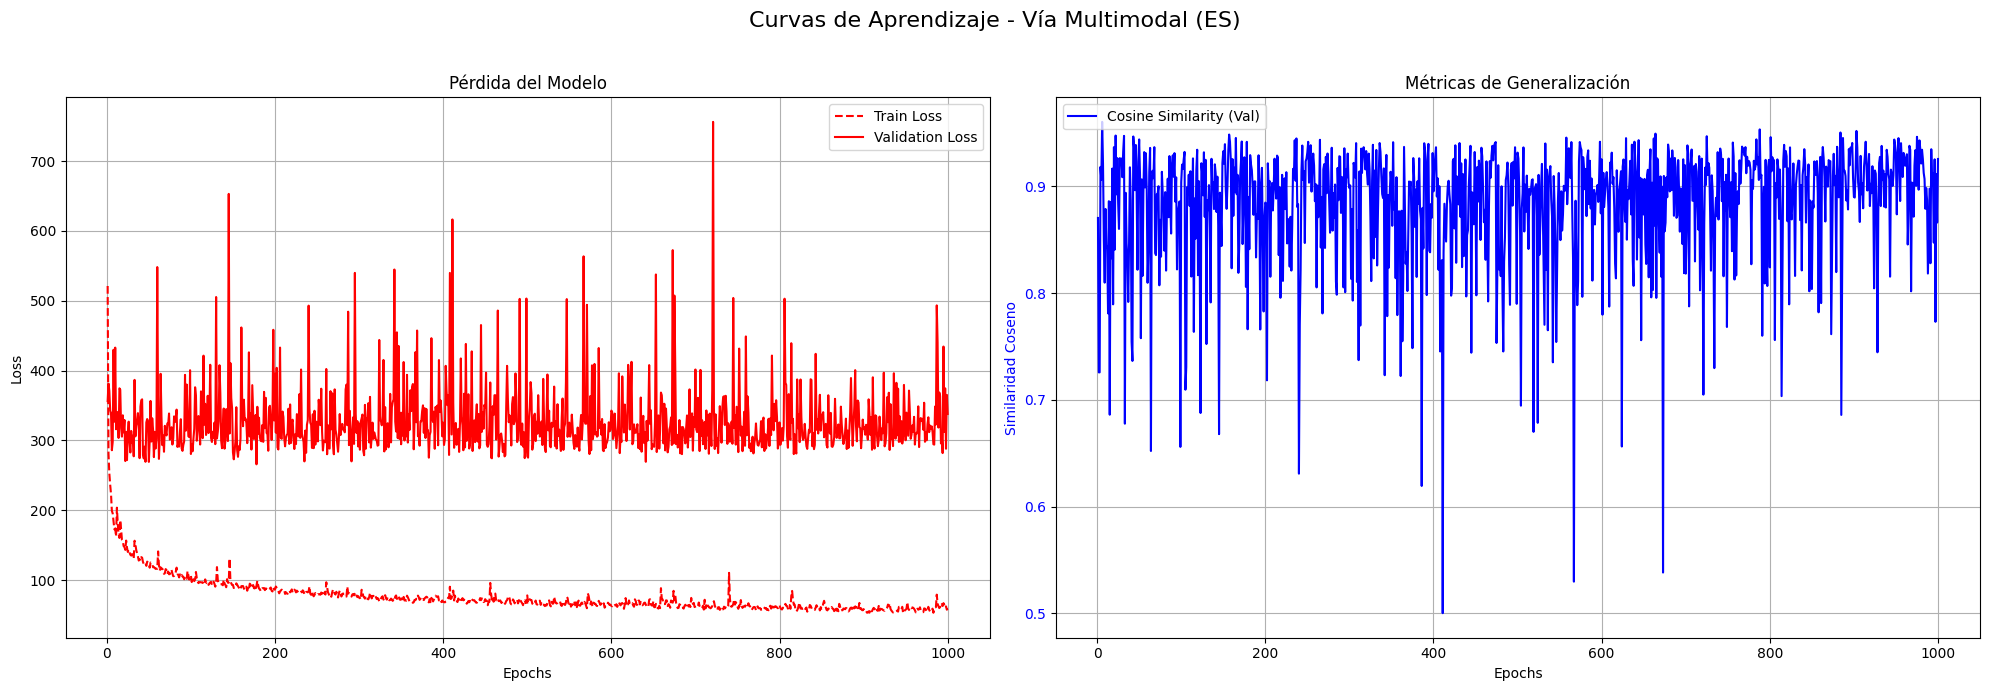


Visualización de evaluación en el set de entrenamiento omitida para optimizar recursos.

Evaluando la generalización sobre datos no vistos y generando tabla de predicciones...


Evaluando en set de validación (es):   0%|          | 0/4 [00:00<?, ?it/s]


--- Tabla de Predicciones en el Set de Validación ---


,Palabra Real,Palabra Predicha,Acierto
0,abertzale,debatiran,False
1,abonar,lucha,False
2,abrazado,indefensas,False
3,absolutos,lucha,False
4,abstinencia,destacado,False
5,abundancia,destacado,False
6,abundante,destacado,False
7,acb,descuentos,False
8,acentuando,destacado,False
9,aceptara,significaran,False



Precisión (Accuracy) en el set de validación: 0.00%

Ejemplos de predicciones incorrectas:


,Palabra Real,Palabra Predicha,Acierto
0,abertzale,debatiran,False
1,abonar,lucha,False
2,abrazado,indefensas,False
3,absolutos,lucha,False
4,abstinencia,destacado,False
5,abundancia,destacado,False
6,abundante,destacado,False
7,acb,descuentos,False
8,acentuando,destacado,False
9,aceptara,significaran,False



Calculando proyección t-SNE...


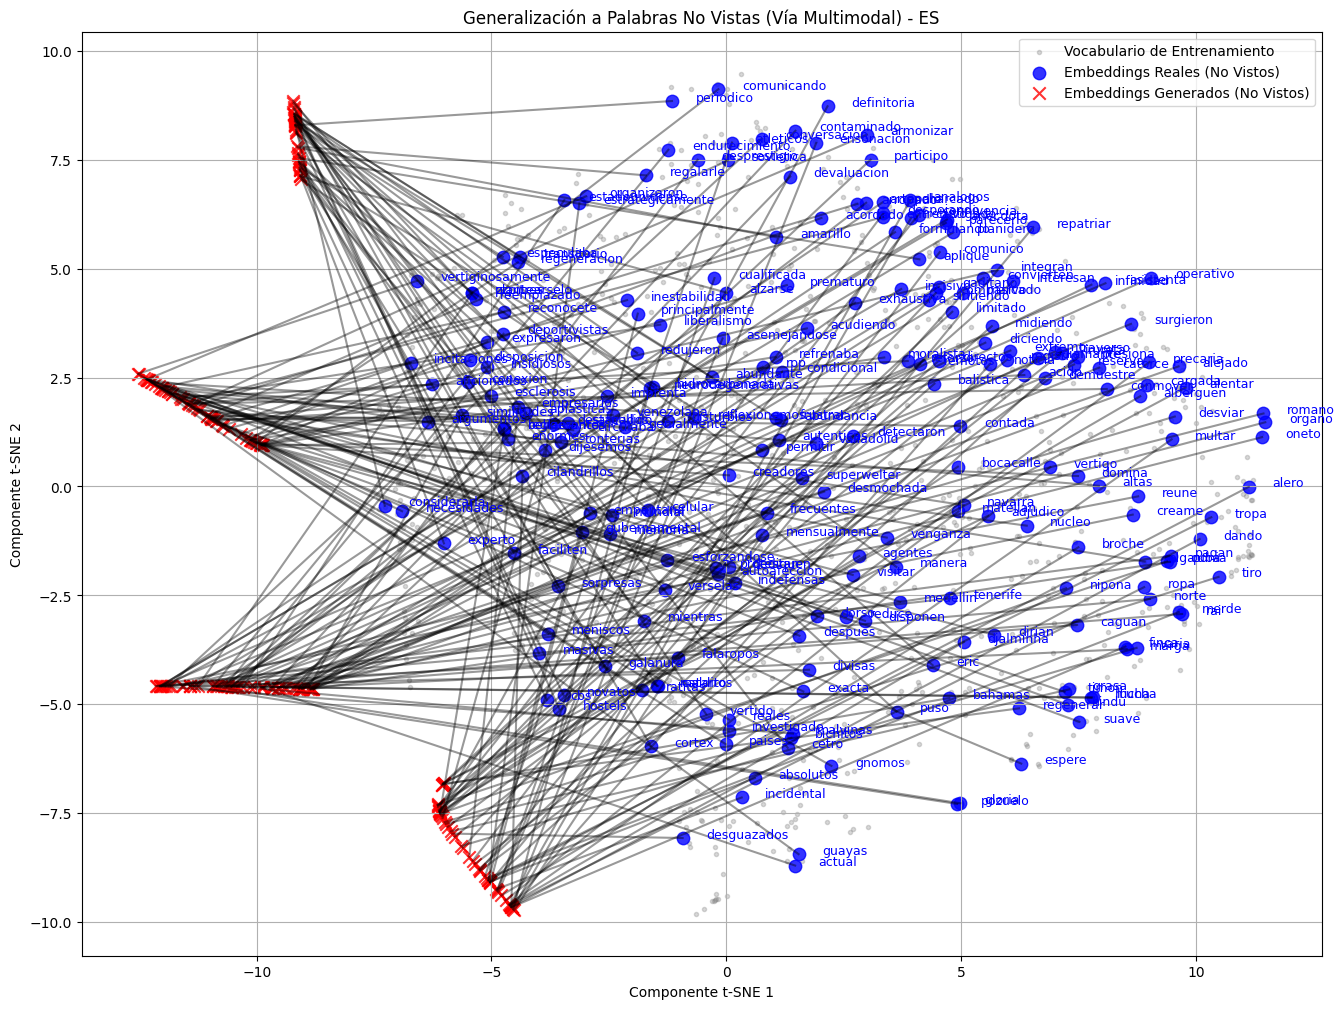

Modelo de la Vía Multimodal para 'es' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/es_multimodal_synthesis.pth

--- Generando Artefactos para la Vía Multimodal de: EN ---


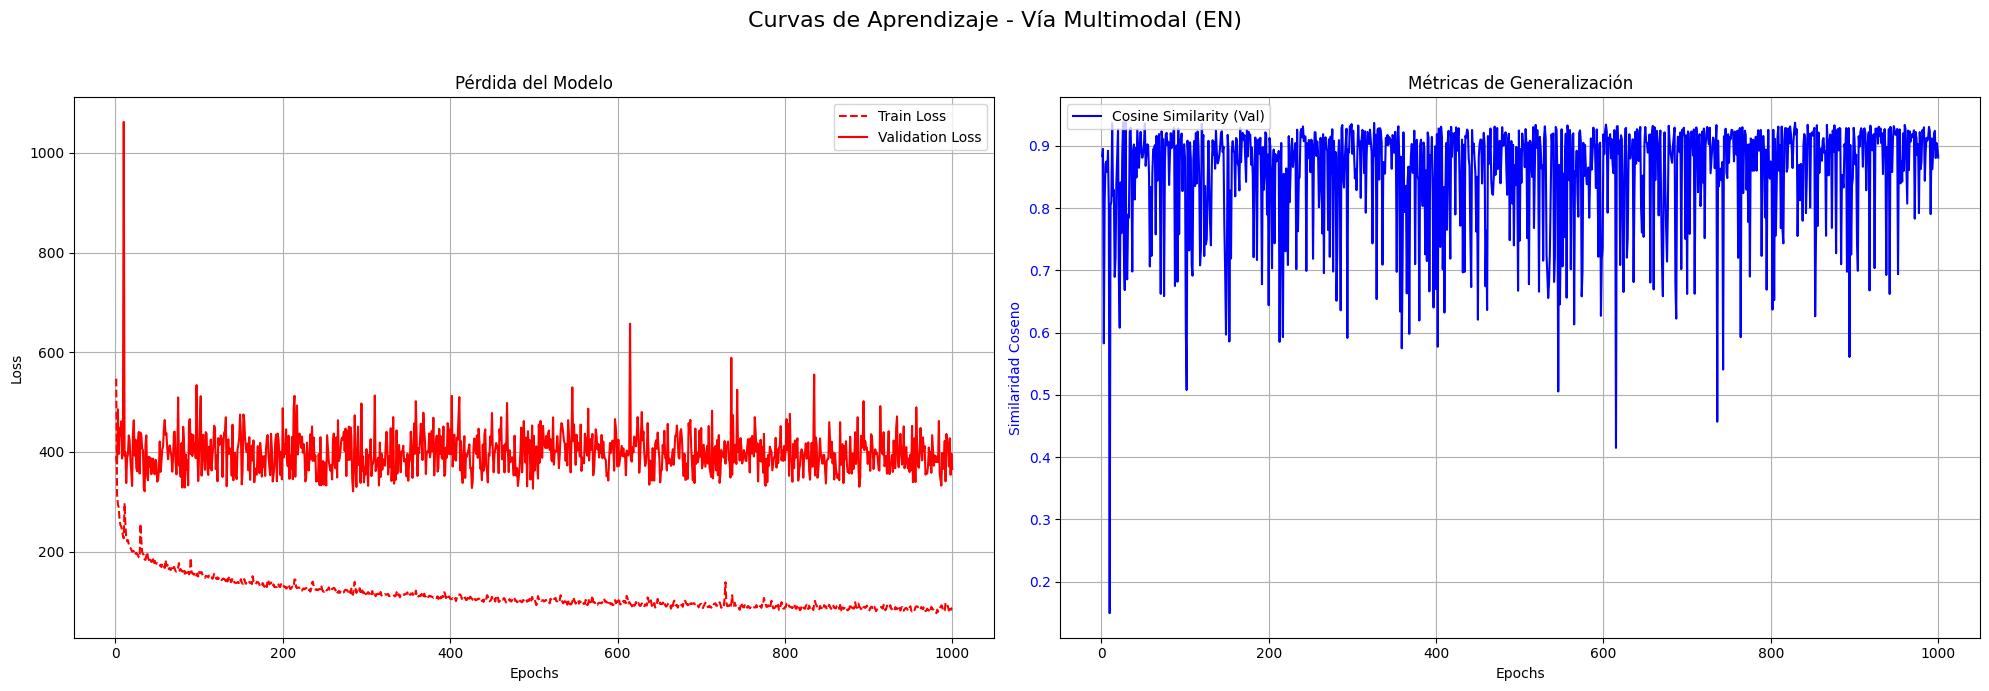


Visualización de evaluación en el set de entrenamiento omitida para optimizar recursos.

Evaluando la generalización sobre datos no vistos y generando tabla de predicciones...


Evaluando en set de validación (en):   0%|          | 0/4 [00:00<?, ?it/s]


--- Tabla de Predicciones en el Set de Validación ---


,Palabra Real,Palabra Predicha,Acierto
0,abie,enanguish,False
1,abnet,hideous,False
2,abolitionize,hideous,False
3,abreaction,enanguish,False
4,abscise,enanguish,False
5,abstriction,hideous,False
6,acarocecidium,hideous,False
7,acetomorphine,enanguish,False
8,acetonization,hideous,False
9,achor,enanguish,False



Precisión (Accuracy) en el set de validación: 0.00%

Ejemplos de predicciones incorrectas:


,Palabra Real,Palabra Predicha,Acierto
0,abie,enanguish,False
1,abnet,hideous,False
2,abolitionize,hideous,False
3,abreaction,enanguish,False
4,abscise,enanguish,False
5,abstriction,hideous,False
6,acarocecidium,hideous,False
7,acetomorphine,enanguish,False
8,acetonization,hideous,False
9,achor,enanguish,False



Calculando proyección t-SNE...


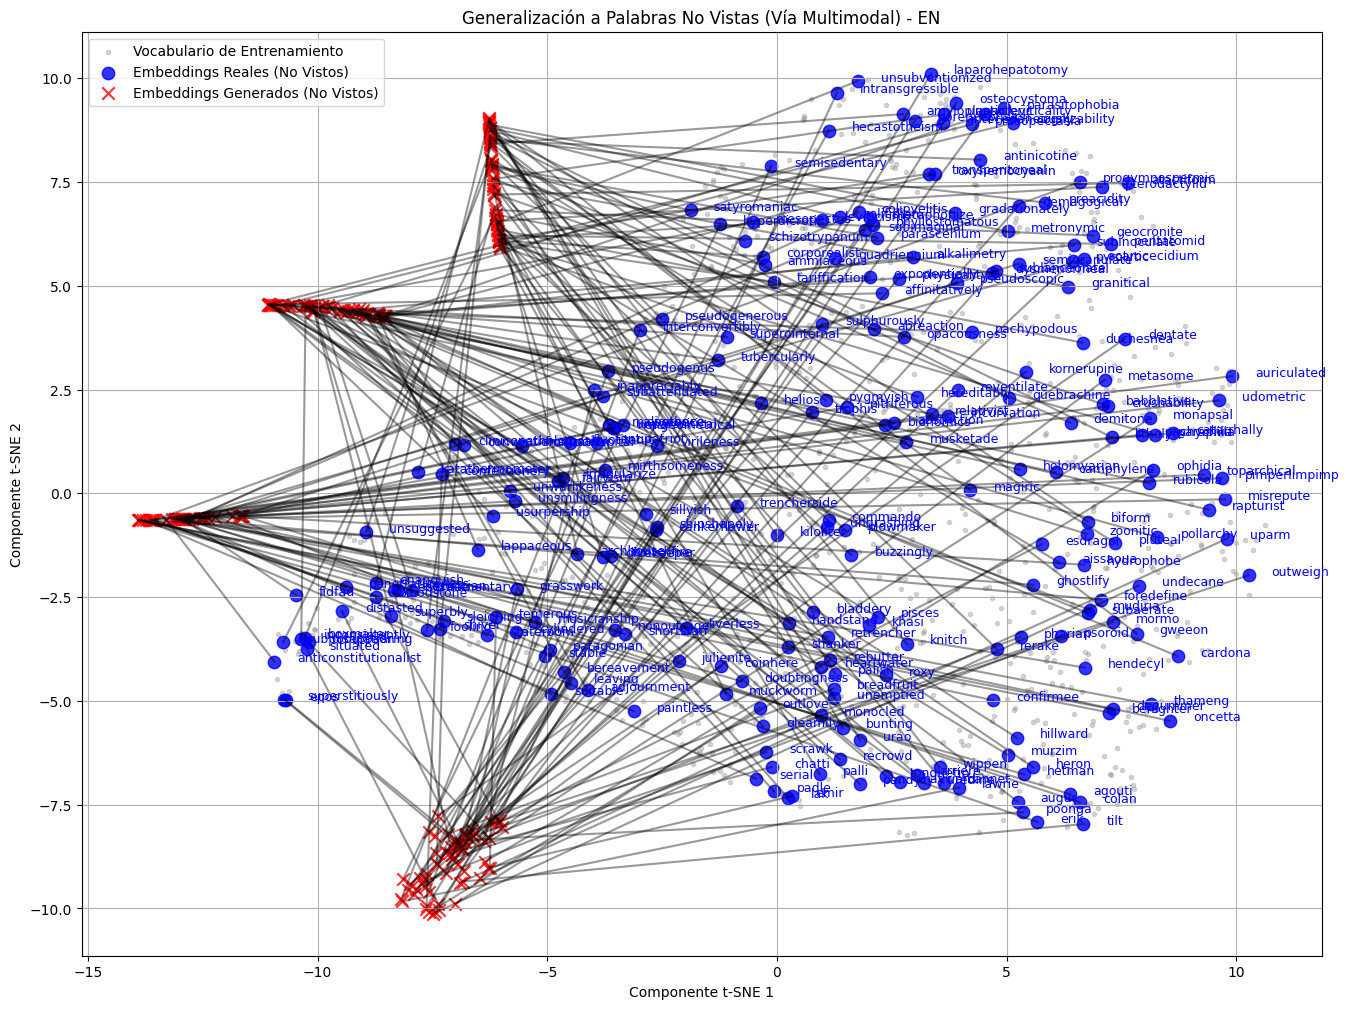

Modelo de la Vía Multimodal para 'en' guardado en: /home/daniel/Proyectos/phonological-awareness/results/trained_models/en_multimodal_synthesis.pth


In [23]:
# ===================================================================
# Celda 10: Fase 2 - Evaluación Final y Visualización de la Vía Multimodal (Modificada)
# ===================================================================

def plot_generative_learning_curves(history, title, file_path):
    """Genera y guarda las curvas de aprendizaje para el modelo generativo."""
    epochs = range(1, len(history.get('train_loss', [])) + 1)
    if not epochs:
        print("No hay datos de historial para graficar.")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle(title, fontsize=16)

    # Gráfico de Pérdida
    ax1.plot(epochs, history.get('train_loss', []), 'r--', label='Train Loss')
    if history.get('val_loss'):
        ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    ax1.set_title('Pérdida del Modelo'); ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

    # Gráfico de Métricas de Generalización
    if history.get('val_cosine_sim'):
        ax2.plot(epochs, history['val_cosine_sim'], 'b-', label='Cosine Similarity (Val)')
        ax2.set_ylabel('Similaridad Coseno', color='b'); ax2.tick_params(axis='y', labelcolor='b'); ax2.legend(loc='upper left')
        ax2.set_title('Métricas de Generalización'); ax2.set_xlabel('Epochs'); ax2.grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(file_path)
    plt.show()

for lang, res in results_multimodal.items():
    print(f"\n--- Generando Artefactos para la Vía Multimodal de: {lang.upper()} ---")
    multimodal_model = res['model']
    history = res['history']
    train_dataset = res['train_dataset']
    val_dataset = res['val_dataset']
    original_label_map = res['original_label_map']
    
    # --- 1. Visualizar Curvas de Aprendizaje ---
    plot_generative_learning_curves(history, f"Curvas de Aprendizaje - Vía Multimodal ({lang.upper()})", figure_dir / f"{lang}_{MODEL_ARCHITECTURE}_learning_curves.png")
    
    # --- 2. Evaluación en Entrenamiento Omitida ---
    # Se omite la generación de la matriz de confusión y el heatmap de logits para ahorrar recursos.
    print("\nVisualización de evaluación en el set de entrenamiento omitida para optimizar recursos.")
    
    # --- 3. Evaluación de Generalización y Predicciones en Validación ---
    print("\nEvaluando la generalización sobre datos no vistos y generando tabla de predicciones...")
    
    # Cargar el clasificador "experto"
    word_expert = SequentialClassifierLSTM(EMBED_DIM, len(original_label_map), LSTM_HIDDEN_DIM, LSTM_N_LAYERS, LSTM_DROPOUT).to(device)
    word_expert.load_state_dict(torch.load(model_dir / f"{lang}_word_expert.pth", map_location=device)['model_state_dict'])
    word_expert.eval()
    
    # Cargar el modelo visual
    visual_model = results_visual[lang]['model']
    visual_model.eval()

    val_loader_eval = DataLoader(val_dataset, batch_size=BATCH_SIZE_MULTIMODAL, shuffle=False, collate_fn=collate_fn_multimodal)
    
    val_real_embeds_mean, val_pred_embeds_mean, val_words = [], [], []
    y_true_val, y_pred_val = [], []

    multimodal_model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader_eval, desc=f"Evaluando en set de validación ({lang})"):
            if batch[0] is None: continue
            
            auditory_input, visual_input, target_seqs, target_lengths, labels, words = batch
            auditory_input, visual_input, target_seqs = auditory_input.to(device), visual_input.to(device), target_seqs.to(device)
            
            batch_size, seq_len, C, H, W = visual_input.shape
            visual_embeddings = visual_model.encoder(visual_input.view(-1, C, H, W)).view(batch_size, seq_len, -1)
            
            fused_input = auditory_input + visual_embeddings
            phoneme_padding_mask = (fused_input.sum(dim=2) == 0)
            
            generated_seq = multimodal_model(fused_input, phoneme_padding_mask, target_seqs, teacher_forcing_ratio=0.0)
            
            # Obtener predicciones del clasificador experto
            logits_out = word_expert(generated_seq, target_lengths)
            preds = logits_out.argmax(1).cpu().numpy()
            y_pred_val.extend(preds)
            y_true_val.extend(labels.cpu().numpy()) # Usamos los labels directamente
            
            # Acumular para t-SNE
            val_real_embeds_mean.append(target_seqs.mean(dim=1).cpu())
            val_pred_embeds_mean.append(generated_seq.mean(dim=1).cpu())
            val_words.extend(words)

    # --- 3.1. Mostrar Tabla de Predicciones ---
    # Invertir el label_map para mapear índices a palabras
    idx_to_word = {v: k for k, v in original_label_map.items()}
    
    # Mapear los índices de predicciones y etiquetas reales a palabras
    predicted_words = [idx_to_word.get(idx, "UNK") for idx in y_pred_val]
    actual_words = [idx_to_word.get(idx, "UNK") for idx in y_true_val]

    # Crear y mostrar el DataFrame
    predictions_df = pd.DataFrame({
        'Palabra Real': actual_words,
        'Palabra Predicha': predicted_words
    })
    
    # Añadir columna de Acierto/Fallo para fácil análisis
    predictions_df['Acierto'] = (predictions_df['Palabra Real'] == predictions_df['Palabra Predicha'])
    
    print("\n--- Tabla de Predicciones en el Set de Validación ---")
    # Mostrar las primeras 20 predicciones como ejemplo
    display(predictions_df.head(20))
    
    # Mostrar resumen de aciertos
    accuracy = predictions_df['Acierto'].mean() * 100
    print(f"\nPrecisión (Accuracy) en el set de validación: {accuracy:.2f}%")
    
    # Opcional: Mostrar las predicciones incorrectas
    print("\nEjemplos de predicciones incorrectas:")
    display(predictions_df[predictions_df['Acierto'] == False].head(10))


    # --- 3.2. Visualización t-SNE ---
    train_loader_eval = DataLoader(train_dataset, batch_size=BATCH_SIZE_MULTIMODAL, shuffle=False, collate_fn=collate_fn_multimodal)
    train_embeds_mean = []
    with torch.no_grad():
        for batch in train_loader_eval:
            if batch[0] is None: continue
            _, _, padded_words, _, _, _ = batch
            train_embeds_mean.append(padded_words.mean(dim=1))

    if val_real_embeds_mean:
        train_embeds_mean=torch.cat(train_embeds_mean).numpy()
        val_real_embeds_mean=torch.cat(val_real_embeds_mean).numpy()
        val_pred_embeds_mean=torch.cat(val_pred_embeds_mean).numpy()
        
        combined_embeds = np.vstack([train_embeds_mean, val_real_embeds_mean, val_pred_embeds_mean])
        
        print("\nCalculando proyección t-SNE..."); 
        tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=min(30, len(combined_embeds)-1), max_iter=300, n_jobs=-1)
        tsne_results = tsne.fit_transform(combined_embeds)
        
        offset=0
        tsne_train=tsne_results[offset:offset+len(train_embeds_mean)]; offset+=len(train_embeds_mean)
        tsne_val_real=tsne_results[offset:offset+len(val_real_embeds_mean)]; offset+=len(val_real_embeds_mean)
        tsne_val_pred=tsne_results[offset:offset+len(val_pred_embeds_mean)]
        
        plt.figure(figsize=(16, 12))
        plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c='gray', marker='.', alpha=0.3, label='Vocabulario de Entrenamiento')
        plt.scatter(tsne_val_real[:, 0], tsne_val_real[:, 1], c='blue', marker='o', s=80, alpha=0.8, label='Embeddings Reales (No Vistos)')
        plt.scatter(tsne_val_pred[:, 0], tsne_val_pred[:, 1], c='red', marker='x', s=80, alpha=0.8, label='Embeddings Generados (No Vistos)')
        
        for i, word in enumerate(val_words):
            plt.plot([tsne_val_real[i, 0], tsne_val_pred[i, 0]], [tsne_val_real[i, 1], tsne_val_pred[i, 1]], 'k-', alpha=0.4)
            plt.text(tsne_val_real[i, 0]+0.5, tsne_val_real[i, 1], word, fontsize=9, color='blue')
            
        plt.title(f'Generalización a Palabras No Vistas (Vía Multimodal) - {lang.upper()}'); plt.xlabel('Componente t-SNE 1'); plt.ylabel('Componente t-SNE 2')
        plt.legend(); plt.grid(True); plt.savefig(figure_dir / f"{lang}_{MODEL_ARCHITECTURE}_tsne_generalization.png"); plt.show()

    # --- 4. Guardado Final del Modelo ---
    model_path = model_dir / f"{lang}_{MODEL_ARCHITECTURE}.pth"
    torch.save(multimodal_model.state_dict(), model_path)
    print(f"Modelo de la Vía Multimodal para '{lang}' guardado en: {model_path}")